## About
This project analyzes student applications and automates admission and scholarship decisions using machine learning.

## Problem Statement
- Manual application review is time-consuming and labor-intensive.  
- Decisions are often subjective and prone to human error.  
- Delays occur in notifying students of admission results.

## Solution
- Generate a synthetic dataset resembling real student applications based on collected data.  
- Train ML models to predict admission and scholarship decisions objectively.  
- Reduce processing time, human bias, and resource consumption while ensuring fair, data-driven outcomes.

## Future Work
- Extend the system for end-to-end application automation.  
- Integrate RAG and LLMs to analyze recommendation letters, verify documents, and conduct automated interviews.  
- Enable scalable, agentic admission analysis for higher accuracy and efficiency.

## Logic we want to follow

## 1. Eligibility Filters (Auto-Reject)

Reject if **any** condition fails:

| Category | Criterion | Threshold |
|-----------|------------|-----------|
| Academic | `previous_gpa` | < 2.5 |
| Recommendation | `recommendation_strength` | < 6 |
| Interview | `interview_score` | < 60 |
| English Programs | TOEFL < 90 / IELTS < 6.0 / DUOLINGO < 90 |
| Chinese Programs | Chinese Proficiency | < HSK4 |

**Result:** `admission_decision = "Rejected"`, `scholarship_tier = "No Scholarship"`


---

## 2. Admission Scoring

Applied **only if all eligibility filters pass**.

| Program Type | Weight Distribution |
|---------------|---------------------|
| **Undergraduate** | 40% GPA • 30% Math/Physics • 10% Recommendation • 20% Interview |
| **Postgraduate** | 40% GPA • 30% Research Alignment • 10% Publications (≤5) • 10% Recommendation • 10% Interview |
| **Chinese/Dual Degree** | 50% GPA • 20% Recommendation • 30% Interview |


---

## 3. Admission Decision

| Admit Score | Decision |
|--------------|-----------|
| < 6.5 | Rejected |
| 6.5–7.5 | Admitted (Borderline) |
| 7.5–8.5 | Admitted (Good) |
| > 8.5 | Admitted (Excellent) |

**Rule:** Score < 6.5 → Rejected; otherwise → Admitted.


---

## 4. Scholarship Allocation

Applied **only to admitted students**.

| Tier | Requirements | Outcome |
|-------|--------------|----------|
| **Full** | admit_score ≥ 8.5 • GPA ≥ 3.6 • recommendation ≥ 8 • interview ≥ 85 | Full Scholarship |
| **Partial** | admit_score ≥ 7.5 • GPA ≥ 3.2 • recommendation ≥ 7 | Partial Scholarship |
| **None** | Admitted but not meeting above | No Scholarship |



## Decision Flow Diagram

```
START
  ↓
┌─────────────────────────────────┐
│ 1. ELIGIBILITY CHECK            │
│ • GPA ≥ 2.5?                    │
│ • Recommendation ≥ 6?           │
│ • Interview ≥ 60?               │
│ • Language requirements met?    │
└─────────────────────────────────┘
  ↓
  NO → REJECTED (No Scholarship)
  ↓ YES
┌─────────────────────────────────┐
│ 2. CALCULATE ADMISSION SCORE    │
│ Based on program category:      │
│ • Undergraduate formula         │
│ • Postgraduate formula          │
│ • Chinese Language formula      │
└─────────────────────────────────┘
  ↓
┌─────────────────────────────────┐
│ 3. ADMISSION DECISION           │
│ • Score < 6.5 → REJECTED        │
│ • Score ≥ 6.5 → ADMITTED        │
└─────────────────────────────────┘
  ↓
  REJECTED → (No Scholarship)
  ↓ ADMITTED
┌─────────────────────────────────┐
│ 4. SCHOLARSHIP EVALUATION       │
│ • Score ≥ 8.5 + high GPA/rec/   │
│   interview → FULL              │
│ • Score ≥ 7.5 + good GPA/rec    │
│   → PARTIAL                     │
│ • Otherwise → NO SCHOLARSHIP    │
└─────────────────────────────────┘
  ↓
END (Admitted with scholarship tier)
```

# EDA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import os

warnings.filterwarnings("ignore")

%matplotlib inline

In [36]:
os.makedirs('./images', exist_ok=True)

In [4]:
path = Path("/teamspace/studios/this_studio/dataset/BIT_Admissions_2025-10-21_12-09-14.csv")

df = pd.read_csv(path)

In [5]:
df.head()

,application_id,program_category,country,bit_program_applied,degree_language,previous_gpa,math_physics_background_score,research_alignment_score,publication_count,recommendation_strength,interview_score,english_test_type,english_score,chinese_proficiency,admission_decision,scholarship_tier
0,BIT20250001,Undergraduate,Morocco,Chemistry and Chemical Engineering,Chinese-taught,2.33,4.7,4.2,0,6.6,68.2,DUOLINGO,77.159382,HSK4,Rejected,No Scholarship
1,BIT20250002,Dual Degree,Mongolia,Joint Mechanical Engineering,English-taught,3.64,8.5,7.9,0,7.3,73.4,TOEFL,109.379735,HSK2,Admitted,Partial Scholarship
2,BIT20250003,Postgraduate,Zimbabwe,Education,English-taught,2.75,3.8,1.7,0,4.7,57.3,TOEFL,75.164883,HSK1,Rejected,No Scholarship
3,BIT20250004,Postgraduate,Mongolia,Design,Chinese-taught,2.32,3.4,1.5,0,6.6,50.6,IELTS,4.375447,HSK3,Rejected,No Scholarship
4,BIT20250005,Undergraduate,Morocco,Foreign Languages,English-taught,3.10,4.5,4.6,0,6.4,89.0,TOEFL,82.506195,HSK1,Rejected,No Scholarship


In [ ]:
"""
Application Id, program applied, country is kind of less important ( at least in this data ) - drop them :)
"""

In [6]:
df.describe()

,previous_gpa,math_physics_background_score,research_alignment_score,publication_count,recommendation_strength,interview_score,english_score
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,2.967430,5.473550,4.943850,0.460500,6.676900,73.079550,55.089937
std,0.527474,1.975831,2.037454,0.822665,1.425269,13.246544,43.860793
min,1.330000,0.000000,0.000000,0.000000,1.600000,30.300000,0.000000
25%,2.590000,4.100000,3.500000,0.000000,5.700000,64.100000,6.338835
50%,2.990000,5.500000,5.000000,0.000000,6.700000,73.400000,66.395732
75%,3.380000,6.900000,6.400000,1.000000,7.700000,82.725000,94.029211
max,4.100000,10.000000,10.000000,6.000000,10.000000,100.000000,155.736333


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   application_id                 2000 non-null   object 
 1   program_category               2000 non-null   object 
 2   country                        2000 non-null   object 
 3   bit_program_applied            2000 non-null   object 
 4   degree_language                2000 non-null   object 
 5   previous_gpa                   2000 non-null   float64
 6   math_physics_background_score  2000 non-null   float64
 7   research_alignment_score       2000 non-null   float64
 8   publication_count              2000 non-null   int64  
 9   recommendation_strength        2000 non-null   float64
 10  interview_score                2000 non-null   float64
 11  english_test_type              2000 non-null   object 
 12  english_score                  2000 non-null   f

In [ ]:
df.columns

Index(['application_id', 'program_category', 'country', 'bit_program_applied',
       'degree_language', 'previous_gpa', 'math_physics_background_score',
       'research_alignment_score', 'publication_count',
       'recommendation_strength', 'interview_score', 'english_test_type',
       'english_score', 'chinese_proficiency', 'admission_decision',
       'scholarship_tier'],
      dtype='object')

In [19]:
df.shape

(2000, 16)

In [22]:
df.isnull().sum()

application_id                   0
program_category                 0
country                          0
bit_program_applied              0
degree_language                  0
previous_gpa                     0
math_physics_background_score    0
research_alignment_score         0
publication_count                0
recommendation_strength          0
interview_score                  0
english_test_type                0
english_score                    0
chinese_proficiency              0
admission_decision               0
scholarship_tier                 0
dtype: int64

In [5]:
cat_data_types = [col for col in df.columns if df[col].dtype == "object"]
num_data_types = [col for col in df.columns if df[col].dtype != "object"]

In [24]:
print(f"Num of catagorical: {len(cat_data_types)}",cat_data_types)
print(f"Num of numeric data: {len(num_data_types)}", num_data_types)

Num of catagorical: 9 ['application_id', 'program_category', 'country', 'bit_program_applied', 'degree_language', 'english_test_type', 'chinese_proficiency', 'admission_decision', 'scholarship_tier']
Num of numeric data: 7 ['previous_gpa', 'math_physics_background_score', 'research_alignment_score', 'publication_count', 'recommendation_strength', 'interview_score', 'english_score']


In [30]:
for col in cat_data_types:
    print(df[col].value_counts(normalize=True).mul(100).round(2))
    print("=========================================================")


application_id
BIT20250001    0.05
BIT20251330    0.05
BIT20251343    0.05
BIT20251342    0.05
BIT20251341    0.05
               ... 
BIT20250662    0.05
BIT20250661    0.05
BIT20250660    0.05
BIT20250659    0.05
BIT20252000    0.05
Name: proportion, Length: 2000, dtype: float64
program_category
Undergraduate       40.30
Postgraduate        34.65
Chinese Language    15.20
Dual Degree          9.85
Name: proportion, dtype: float64
country
Morocco       7.25
Zimbabwe      7.20
Thailand      7.20
Kenya         7.15
Pakistan      7.15
France        6.95
Kazakhstan    6.85
Russia        6.70
Egypt         6.70
Ethiopia      6.50
Indonesia     6.25
India         6.25
Mongolia      6.20
Malaysia      5.90
Brazil        5.75
Name: proportion, dtype: float64
bit_program_applied
Chinese Language and Culture                             15.20
Joint Computer Science Program                            3.85
Cyberspace Science and Technology                         3.65
Law                          

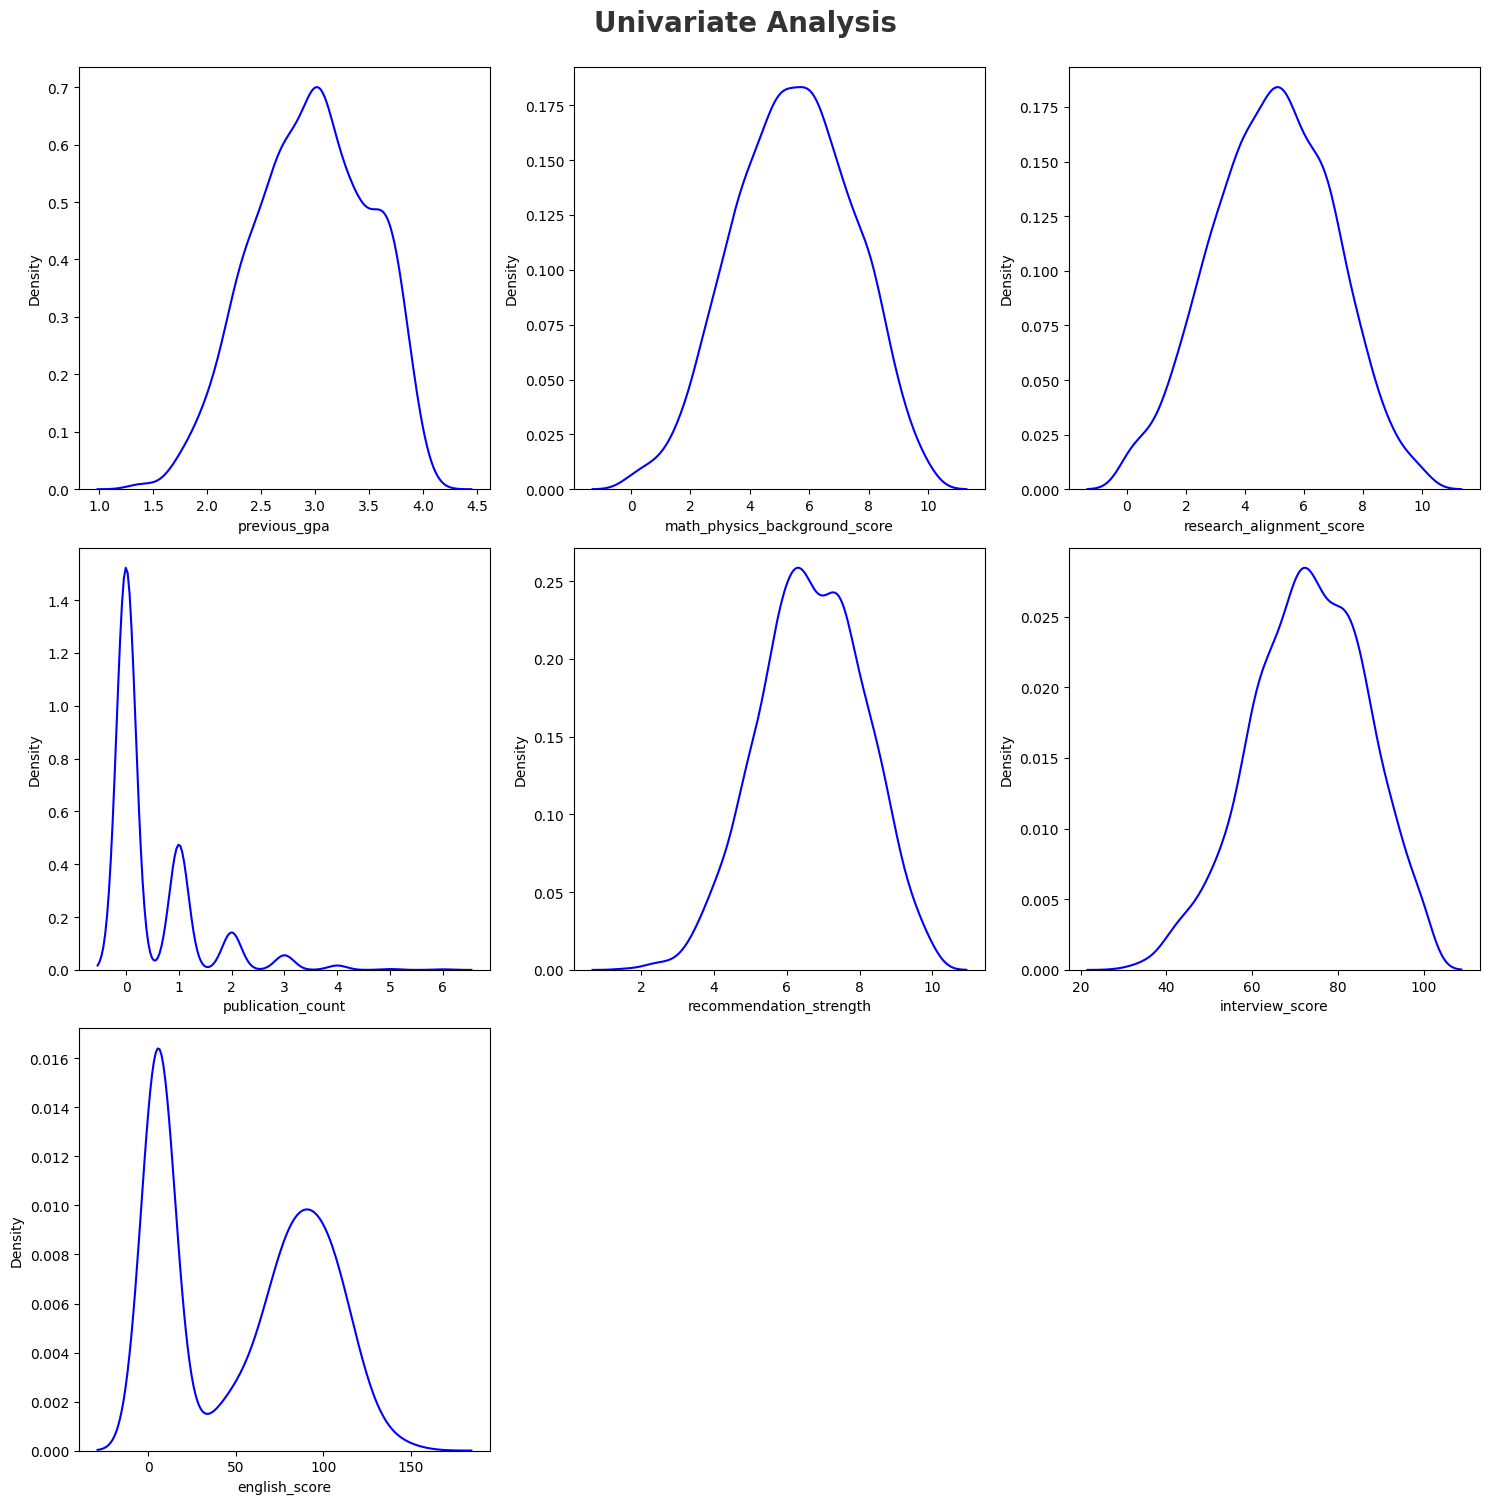

In [37]:
n_cols = len(num_data_types)
n_rows = (n_cols + 2) // 3  
plt.figure(figsize=(15, 5 * n_rows))
plt.suptitle('Univariate Analysis', fontsize=20, fontweight='bold', alpha=0.8, y=1.)

for i in range(0, len(num_data_types)):
    plt.subplot(n_rows, 3, i+1)
    sns.kdeplot(x=df[num_data_types[i]], color='blue')
    plt.xlabel(num_data_types[i])
    plt.tight_layout()
    
# save plot
plt.savefig('./images/Univariate_Num.png')

In [ ]:
# wtf is the publication count

<Figure size 1500x1500 with 0 Axes>

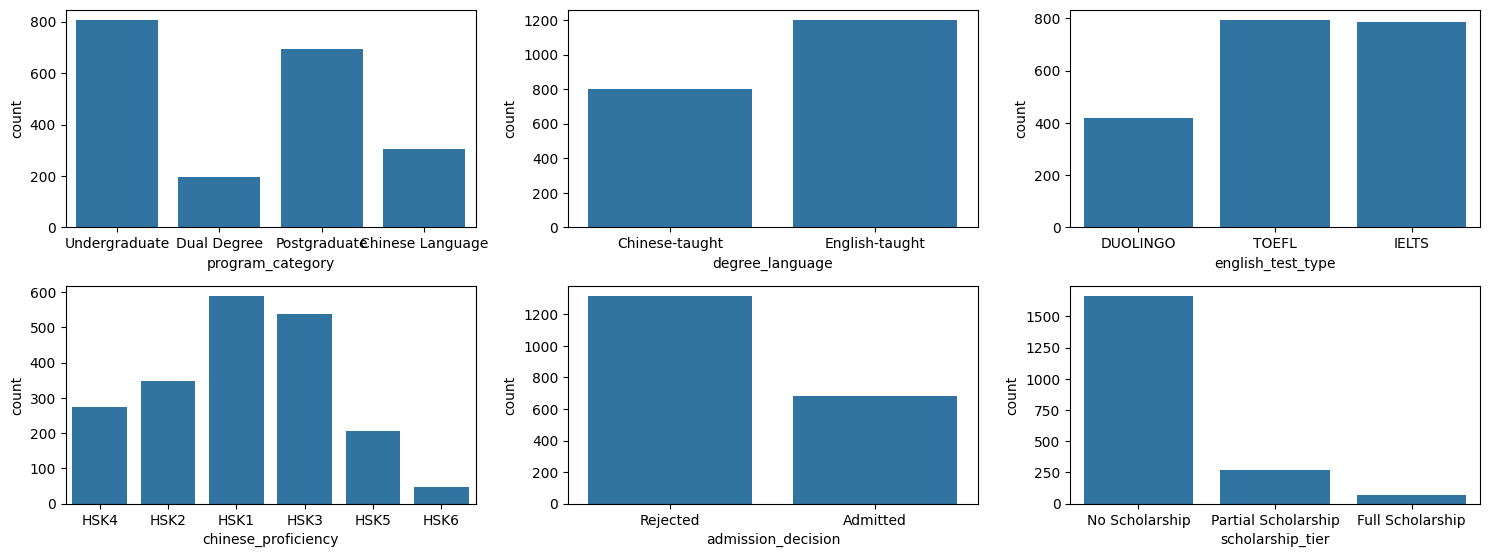

In [6]:
n_cols = len(cat_data_types)
n_rows = (n_cols + 2) // 3  
plt.figure(figsize=(15, 5 * n_rows))
plt.suptitle('Cat Analysis', fontsize=20, fontweight='bold', alpha=0.8, y=1.)

cat_data_types.remove('application_id')
cat_data_types.remove('country')
cat_data_types.remove('bit_program_applied')
plt.figure(figsize=(15, 8))

for i in range(0, len(cat_data_types)):
    plt.subplot(n_rows, 3, i+1)
    sns.countplot(x=df[cat_data_types[i]])
    plt.xlabel(cat_data_types[i])
    plt.tight_layout()
    
# save plot
plt.savefig('./images/Univariate_Cat.png')

In [ ]:
# scholarship status --- True data never lies LOLLL

In [7]:
discrete_features=[feature for feature in num_data_types if len(df[feature].unique())<=25]
continuous_features=[feature for feature in num_data_types if len(df[feature].unique()) > 25]

In [8]:
print('We have {} discrete features : {}'.format(len(discrete_features), discrete_features))
print('\nWe have {} continuous_features : {}'.format(len(continuous_features), continuous_features))

We have 1 discrete features : ['publication_count']

We have 6 continuous_features : ['previous_gpa', 'math_physics_background_score', 'research_alignment_score', 'recommendation_strength', 'interview_score', 'english_score']


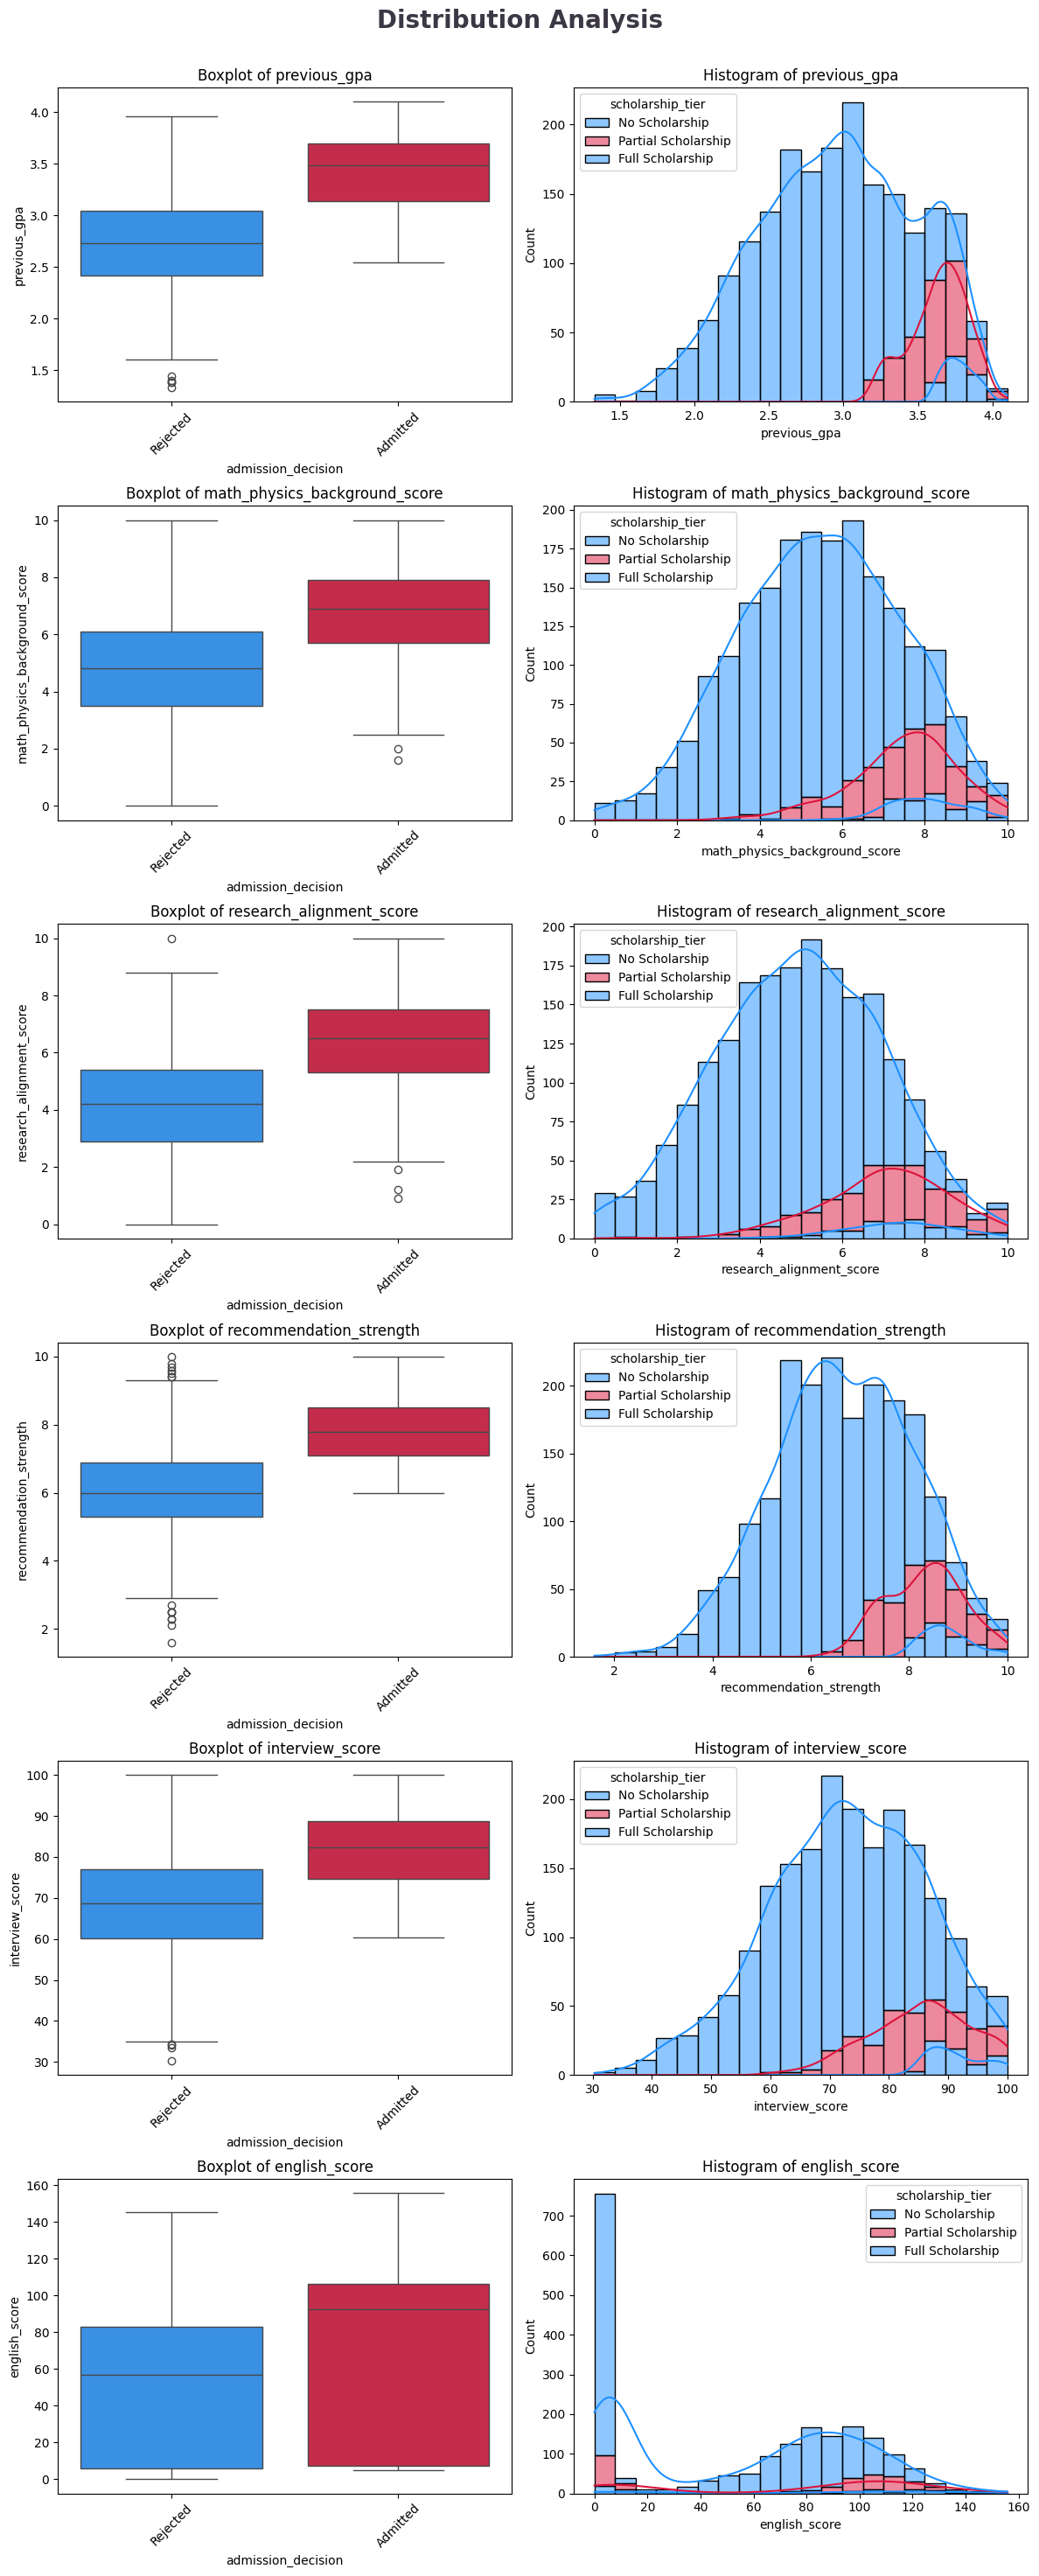

In [10]:
clr1 = ['#1E90FF', '#DC143C']

n_features = len(continuous_features)
n_rows = n_features
fig, ax = plt.subplots(n_rows, 2, figsize=(12, 5 * n_rows))
fig.suptitle('Distribution Analysis', color='#3C3744',
             fontsize=20, fontweight='bold', ha='center')

for i, col in enumerate(continuous_features):   
    sns.boxplot(data=df, x='admission_decision', y=col, palette=clr1, ax=ax[i, 0])
    ax[i, 0].set_title(f'Boxplot of {col}', fontsize=12)
    ax[i, 0].tick_params(axis='x', rotation=45)
    
    # Use scholarship_tier
    sns.histplot(data=df, x=col, hue='scholarship_tier', bins=20, kde=True, 
                 multiple='stack', palette=clr1, ax=ax[i, 1])
    ax[i, 1].set_title(f'Histogram of {col}', fontsize=12)

fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.savefig('./images/multivariate_num.png')

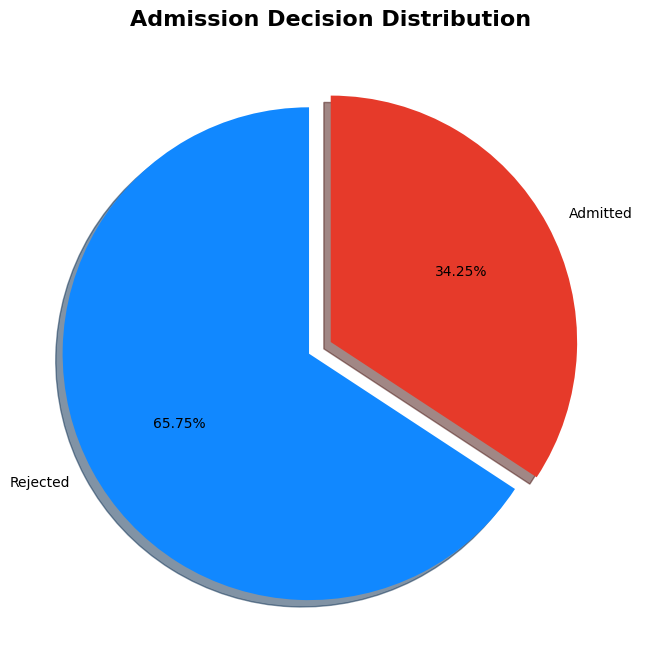

In [12]:
# dmission Decision distribution
percentage = df.admission_decision.value_counts(normalize=True)*100
labels = percentage.index.tolist()  

fig, ax = plt.subplots(figsize=(15, 8))
explode = tuple([0.1 if i == 0 else 0 for i in range(len(labels))])  
colors = ['#1188ff', '#e63a2a']
ax.pie(percentage, labels=labels, startangle=90,
       autopct='%1.2f%%', explode=explode, shadow=True, colors=colors)
ax.set_title('Admission Decision Distribution', fontsize=16, fontweight='bold')
plt.savefig('./images/admission_pie.png')
plt.show()

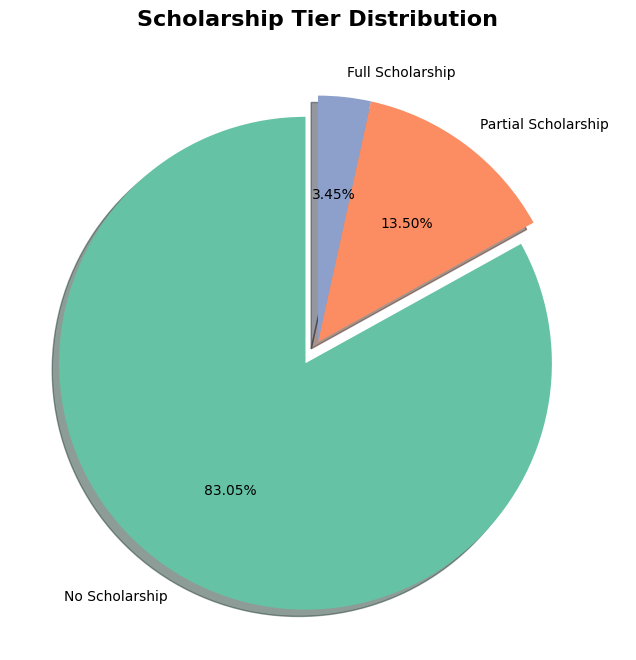

In [13]:
# cholarship Tier distribution
percentage = df.scholarship_tier.value_counts(normalize=True)*100
labels = percentage.index.tolist()

fig, ax = plt.subplots(figsize=(15, 8))
explode = tuple([0.1 if i == 0 else 0 for i in range(len(labels))])
colors = sns.color_palette('Set2', len(labels))
ax.pie(percentage, labels=labels, startangle=90,
       autopct='%1.2f%%', explode=explode, shadow=True, colors=colors)
ax.set_title('Scholarship Tier Distribution', fontsize=16, fontweight='bold')
plt.savefig('./images/scholarship_pie.png')
plt.show()

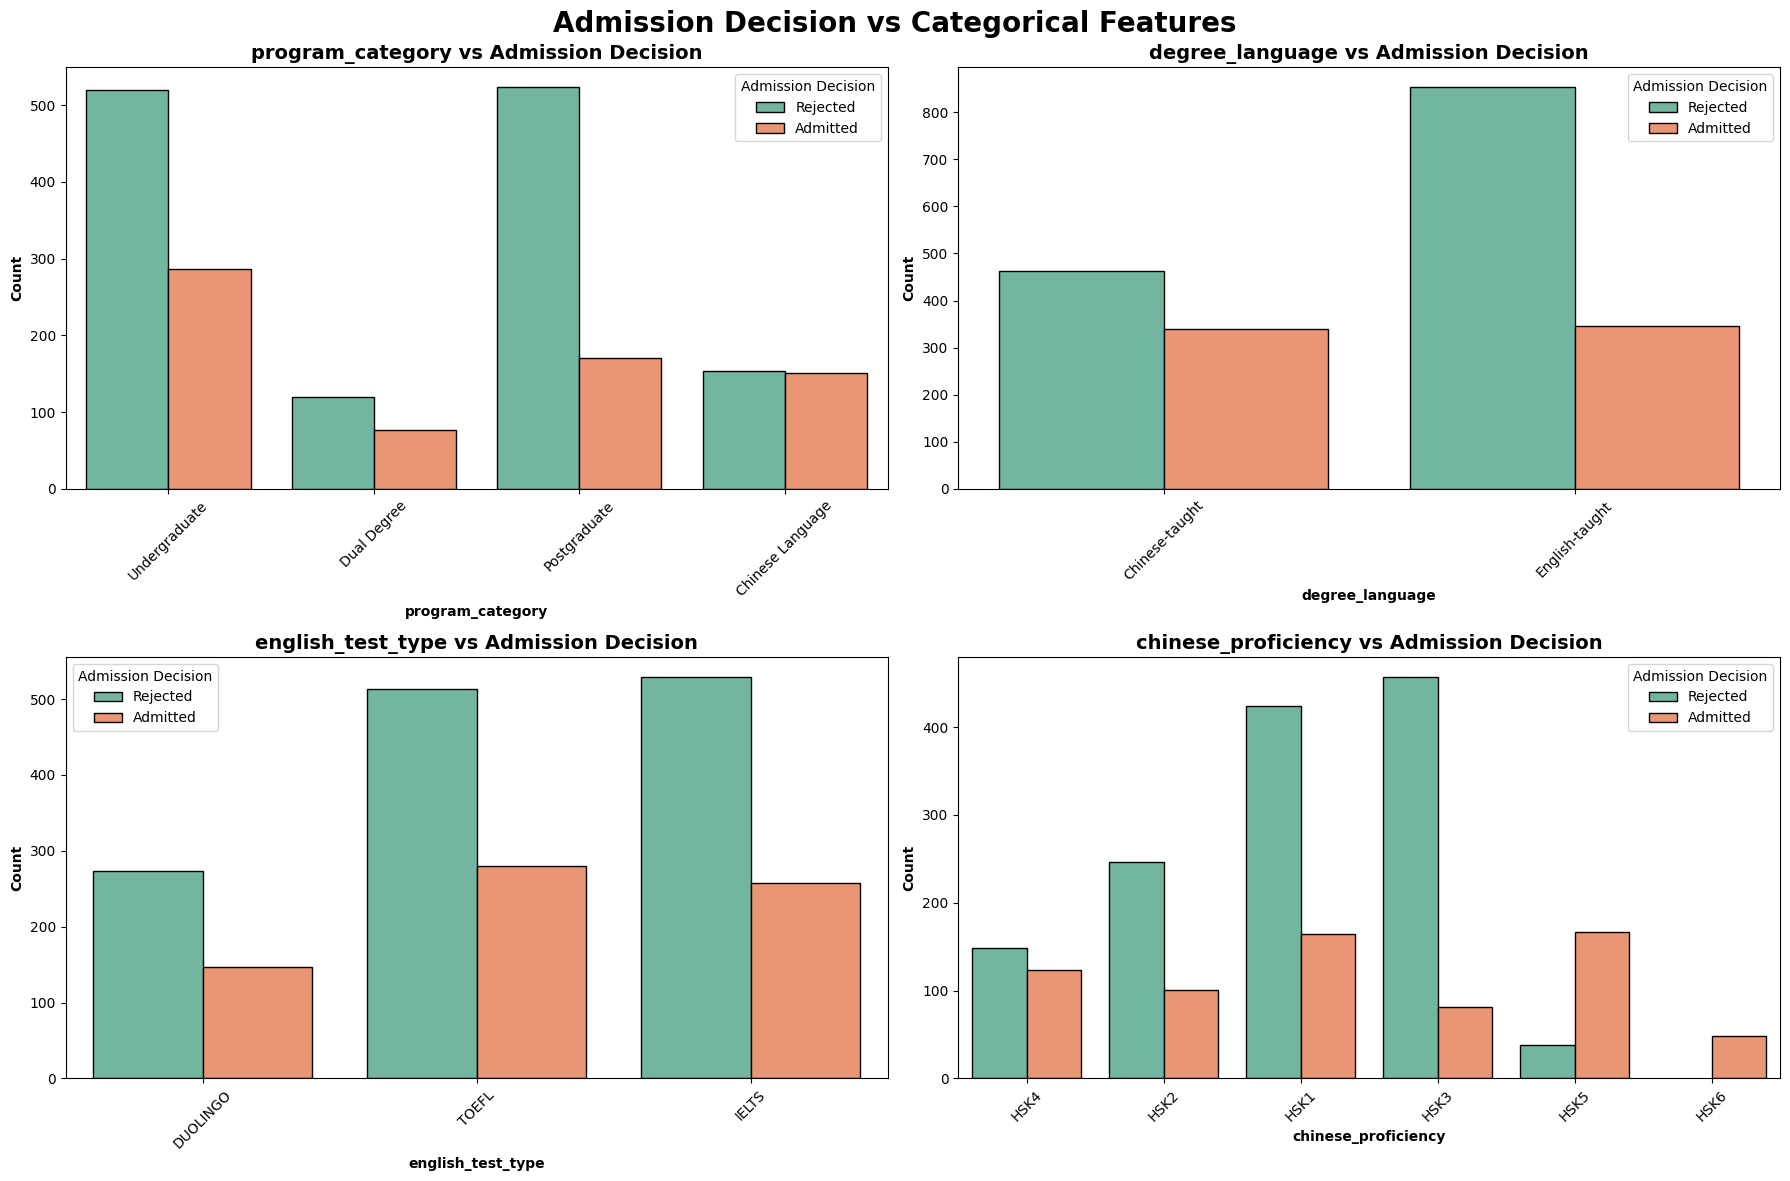

In [16]:
# Admission Decision vs Categorical Features
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Admission Decision vs Categorical Features', fontsize=20, fontweight='bold')

# Get relevant categorical features (excluding IDs and targets)
cat_features = [col for col in cat_data_types if col not in ['application_id', 'country', 'bit_program_applied', 'admission_decision', 'scholarship_tier']]

for idx, feature in enumerate(cat_features):  # Plot first 4 categorical features
    row, col = idx // 2, idx % 2
    sns.countplot(x=feature, hue='admission_decision', data=df, 
                  ec='black', palette='Set2', ax=axes[row, col])
    axes[row, col].set_title(f'{feature} vs Admission Decision', 
                            fontsize=14, fontweight='bold')
    axes[row, col].set_xlabel(feature, fontweight='bold')
    axes[row, col].set_ylabel('Count', fontweight='bold')
    axes[row, col].legend(title='Admission Decision', fancybox=True)
    axes[row, col].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('./images/admission_vs_categorical.png')
plt.show()

In [17]:
# Groupby Analysis - Admission Decision vs Continuous Features
print("=" * 80)
print("ADMISSION DECISION VS CONTINUOUS FEATURES - STATISTICAL SUMMARY")
print("=" * 80)

for feature in continuous_features:
    print(f"\n{feature.upper()}")
    print("-" * 80)
    summary = df.groupby('admission_decision')[feature].agg(['mean', 'median', 'std', 'min', 'max'])
    print(summary)
    print()

ADMISSION DECISION VS CONTINUOUS FEATURES - STATISTICAL SUMMARY

PREVIOUS_GPA
--------------------------------------------------------------------------------
                        mean  median       std   min   max
admission_decision                                        
Admitted            3.418131    3.48  0.337342  2.54  4.10
Rejected            2.732654    2.73  0.450531  1.33  3.96


MATH_PHYSICS_BACKGROUND_SCORE
--------------------------------------------------------------------------------
                        mean  median       std  min   max
admission_decision                                       
Admitted            6.747591     6.9  1.589526  1.6  10.0
Rejected            4.809886     4.8  1.826711  0.0  10.0


RESEARCH_ALIGNMENT_SCORE
--------------------------------------------------------------------------------
                        mean  median       std  min   max
admission_decision                                       
Admitted            6.402044     6.5

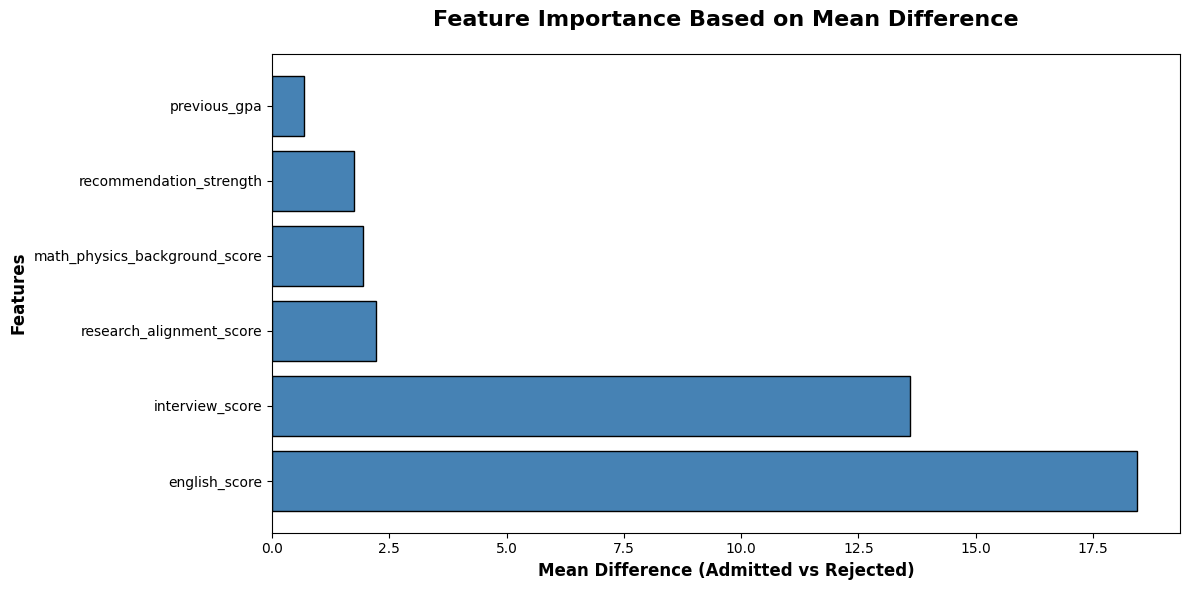


Feature Importance Ranking:
                         Feature  Admitted_Mean  Rejected_Mean  Difference
5                  english_score      67.210137      48.776372   18.433764
4                interview_score      82.024526      68.420000   13.604526
2       research_alignment_score       6.402044       4.184259    2.217785
1  math_physics_background_score       6.747591       4.809886    1.937705
3        recommendation_strength       7.824526       6.079087    1.745438
0                   previous_gpa       3.418131       2.732654    0.685477


In [18]:
# Feature Importance Analysis - Mean values comparison
feature_importance = pd.DataFrame()

for feature in continuous_features:
    admitted_mean = df[df['admission_decision'] == 'Admitted'][feature].mean()
    rejected_mean = df[df['admission_decision'] == 'Rejected'][feature].mean()
    difference = abs(admitted_mean - rejected_mean)
    
    feature_importance = pd.concat([feature_importance, pd.DataFrame({
        'Feature': [feature],
        'Admitted_Mean': [admitted_mean],
        'Rejected_Mean': [rejected_mean],
        'Difference': [difference]
    })], ignore_index=True)

feature_importance = feature_importance.sort_values('Difference', ascending=False)

# Visualize feature importance
plt.figure(figsize=(12, 6))
plt.barh(feature_importance['Feature'], feature_importance['Difference'], 
         color='steelblue', edgecolor='black')
plt.xlabel('Mean Difference (Admitted vs Rejected)', fontweight='bold', fontsize=12)
plt.ylabel('Features', fontweight='bold', fontsize=12)
plt.title('Feature Importance Based on Mean Difference', 
          fontweight='bold', fontsize=16, pad=20)
plt.tight_layout()
plt.savefig('./images/feature_importance.png')
plt.show()

print("\nFeature Importance Ranking:")
print(feature_importance)

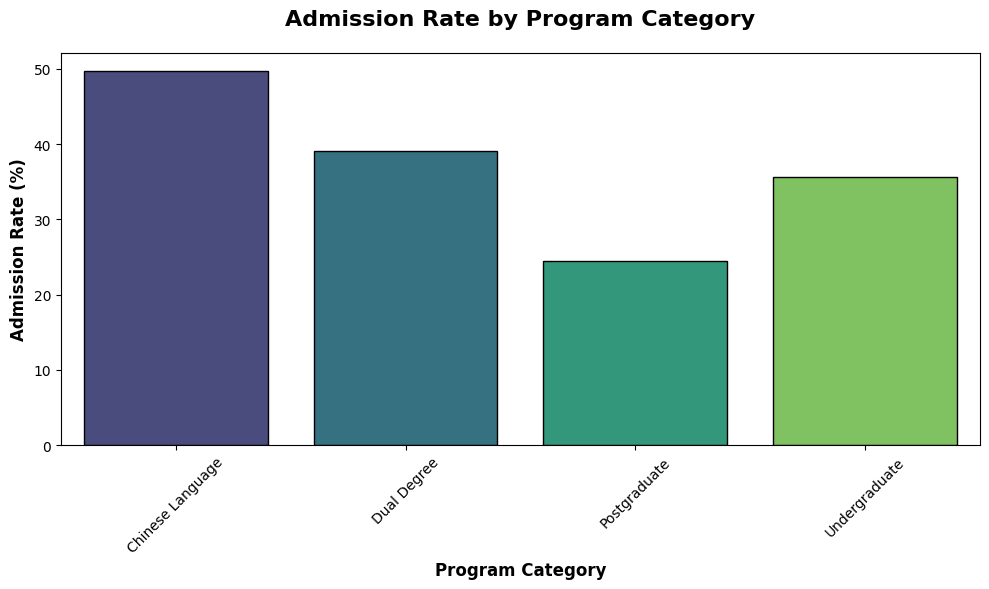


Admission Rates by Program Category:
   program_category  admission_rate
0  Chinese Language       49.671053
1       Dual Degree       39.086294
2      Postgraduate       24.531025
3     Undergraduate       35.607940


In [19]:
# Admission Rate by Program Category
admission_rate = df.groupby('program_category')['admission_decision'].apply(
    lambda x: (x == 'Admitted').sum() / len(x) * 100
).reset_index()
admission_rate.columns = ['program_category', 'admission_rate']

plt.figure(figsize=(10, 6))
sns.barplot(x='program_category', y='admission_rate', data=admission_rate, 
            palette='viridis', edgecolor='black')
plt.title('Admission Rate by Program Category', fontweight='bold', fontsize=16, pad=20)
plt.xlabel('Program Category', fontweight='bold', fontsize=12)
plt.ylabel('Admission Rate (%)', fontweight='bold', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./images/admission_rate_by_program.png')
plt.show()

print("\nAdmission Rates by Program Category:")
print(admission_rate)

GPA VS ADMISSION DECISION - DETAILED ANALYSIS

Statistical Summary:
                    count   mean  median    std   min   max
admission_decision                                         
Admitted              685  3.418    3.48  0.337  2.54  4.10
Rejected             1315  2.733    2.73  0.451  1.33  3.96


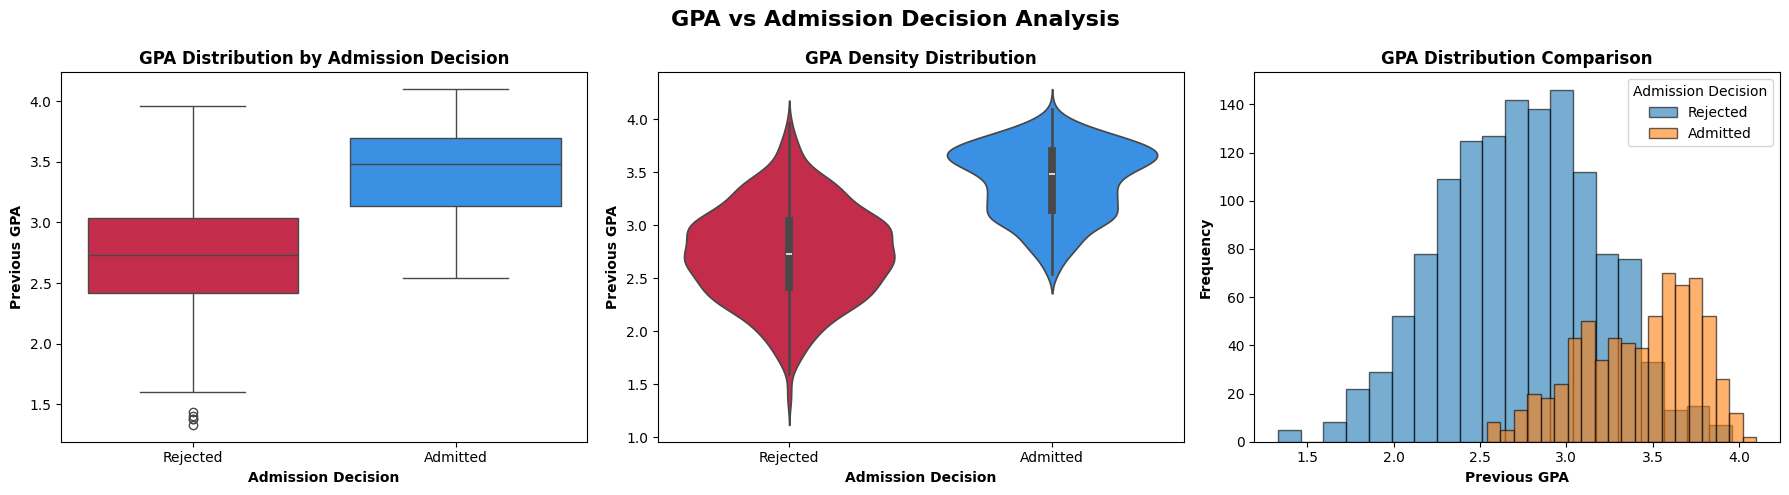

In [21]:
# GPA vs Admission Decision - Detailed Analysis
print("=" * 80)
print("GPA VS ADMISSION DECISION - DETAILED ANALYSIS")
print("=" * 80)

# Statistical summary
gpa_admission_summary = df.groupby('admission_decision')['previous_gpa'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max'
]).round(3)
print("\nStatistical Summary:")
print(gpa_admission_summary)

# Create visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('GPA vs Admission Decision Analysis', fontsize=16, fontweight='bold')

# Box plot
sns.boxplot(data=df, x='admission_decision', y='previous_gpa', 
            palette=['#DC143C', '#1E90FF'], ax=axes[0])
axes[0].set_title('GPA Distribution by Admission Decision', fontweight='bold')
axes[0].set_ylabel('Previous GPA', fontweight='bold')
axes[0].set_xlabel('Admission Decision', fontweight='bold')

# Violin plot
sns.violinplot(data=df, x='admission_decision', y='previous_gpa', 
               palette=['#DC143C', '#1E90FF'], ax=axes[1])
axes[1].set_title('GPA Density Distribution', fontweight='bold')
axes[1].set_ylabel('Previous GPA', fontweight='bold')
axes[1].set_xlabel('Admission Decision', fontweight='bold')

# Histogram with KDE
for decision in df['admission_decision'].unique():
    data = df[df['admission_decision'] == decision]['previous_gpa']
    axes[2].hist(data, alpha=0.6, label=decision, bins=20, edgecolor='black')
axes[2].set_title('GPA Distribution Comparison', fontweight='bold')
axes[2].set_xlabel('Previous GPA', fontweight='bold')
axes[2].set_ylabel('Frequency', fontweight='bold')
axes[2].legend(title='Admission Decision')

plt.tight_layout()
plt.savefig('./images/gpa_vs_admission.png', dpi=300, bbox_inches='tight')
plt.show()


GPA VS SCHOLARSHIP TIER - DETAILED ANALYSIS

Statistical Summary:
                     count   mean  median    std   min   max
scholarship_tier                                            
Full Scholarship        69  3.777    3.76  0.106  3.61  4.10
No Scholarship        1661  2.830    2.86  0.465  1.33  4.02
Partial Scholarship    270  3.604    3.62  0.193  3.20  4.04


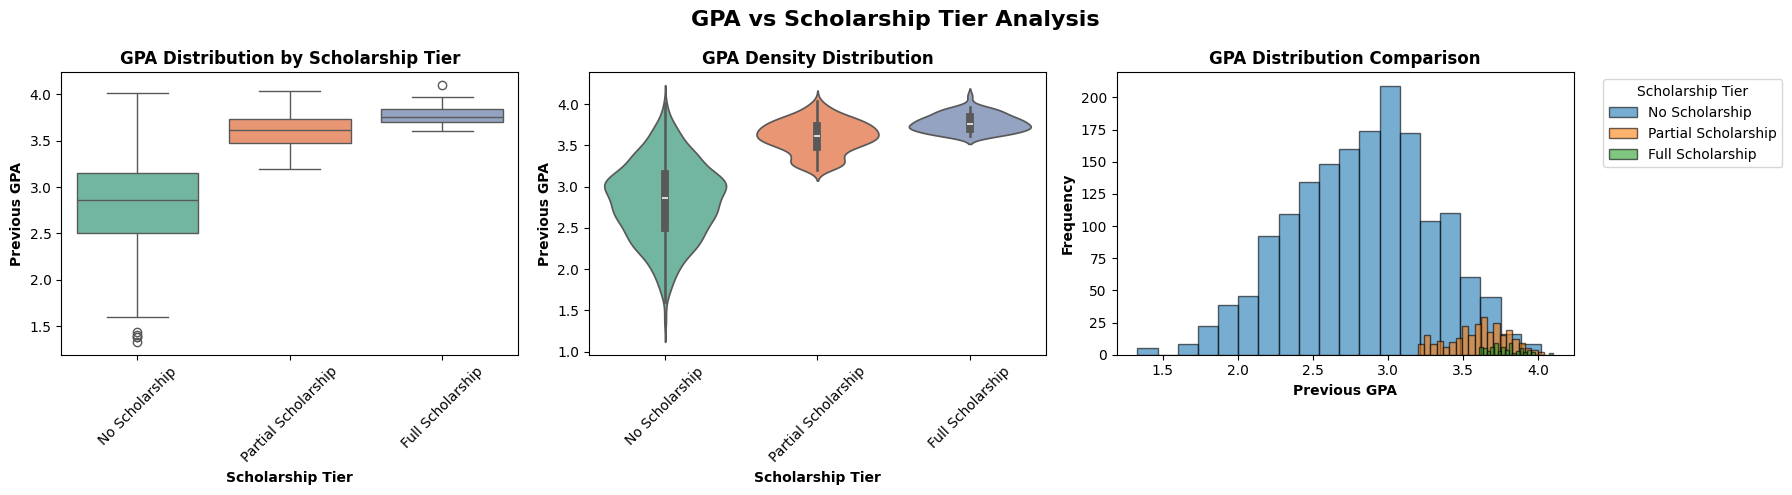

In [22]:
# GPA vs Scholarship Tier - Detailed Analysis
print("\n" + "=" * 80)
print("GPA VS SCHOLARSHIP TIER - DETAILED ANALYSIS")
print("=" * 80)

# Statistical summary
gpa_scholarship_summary = df.groupby('scholarship_tier')['previous_gpa'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max'
]).round(3)
print("\nStatistical Summary:")
print(gpa_scholarship_summary)

# Create visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('GPA vs Scholarship Tier Analysis', fontsize=16, fontweight='bold')

# Box plot
sns.boxplot(data=df, x='scholarship_tier', y='previous_gpa', 
            palette='Set2', ax=axes[0])
axes[0].set_title('GPA Distribution by Scholarship Tier', fontweight='bold')
axes[0].set_ylabel('Previous GPA', fontweight='bold')
axes[0].set_xlabel('Scholarship Tier', fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)

# Violin plot
sns.violinplot(data=df, x='scholarship_tier', y='previous_gpa', 
               palette='Set2', ax=axes[1])
axes[1].set_title('GPA Density Distribution', fontweight='bold')
axes[1].set_ylabel('Previous GPA', fontweight='bold')
axes[1].set_xlabel('Scholarship Tier', fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)

# Histogram with KDE
for tier in df['scholarship_tier'].unique():
    data = df[df['scholarship_tier'] == tier]['previous_gpa']
    axes[2].hist(data, alpha=0.6, label=tier, bins=20, edgecolor='black')
axes[2].set_title('GPA Distribution Comparison', fontweight='bold')
axes[2].set_xlabel('Previous GPA', fontweight='bold')
axes[2].set_ylabel('Frequency', fontweight='bold')
axes[2].legend(title='Scholarship Tier', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.savefig('./images/gpa_vs_scholarship.png', dpi=300, bbox_inches='tight')
plt.show()

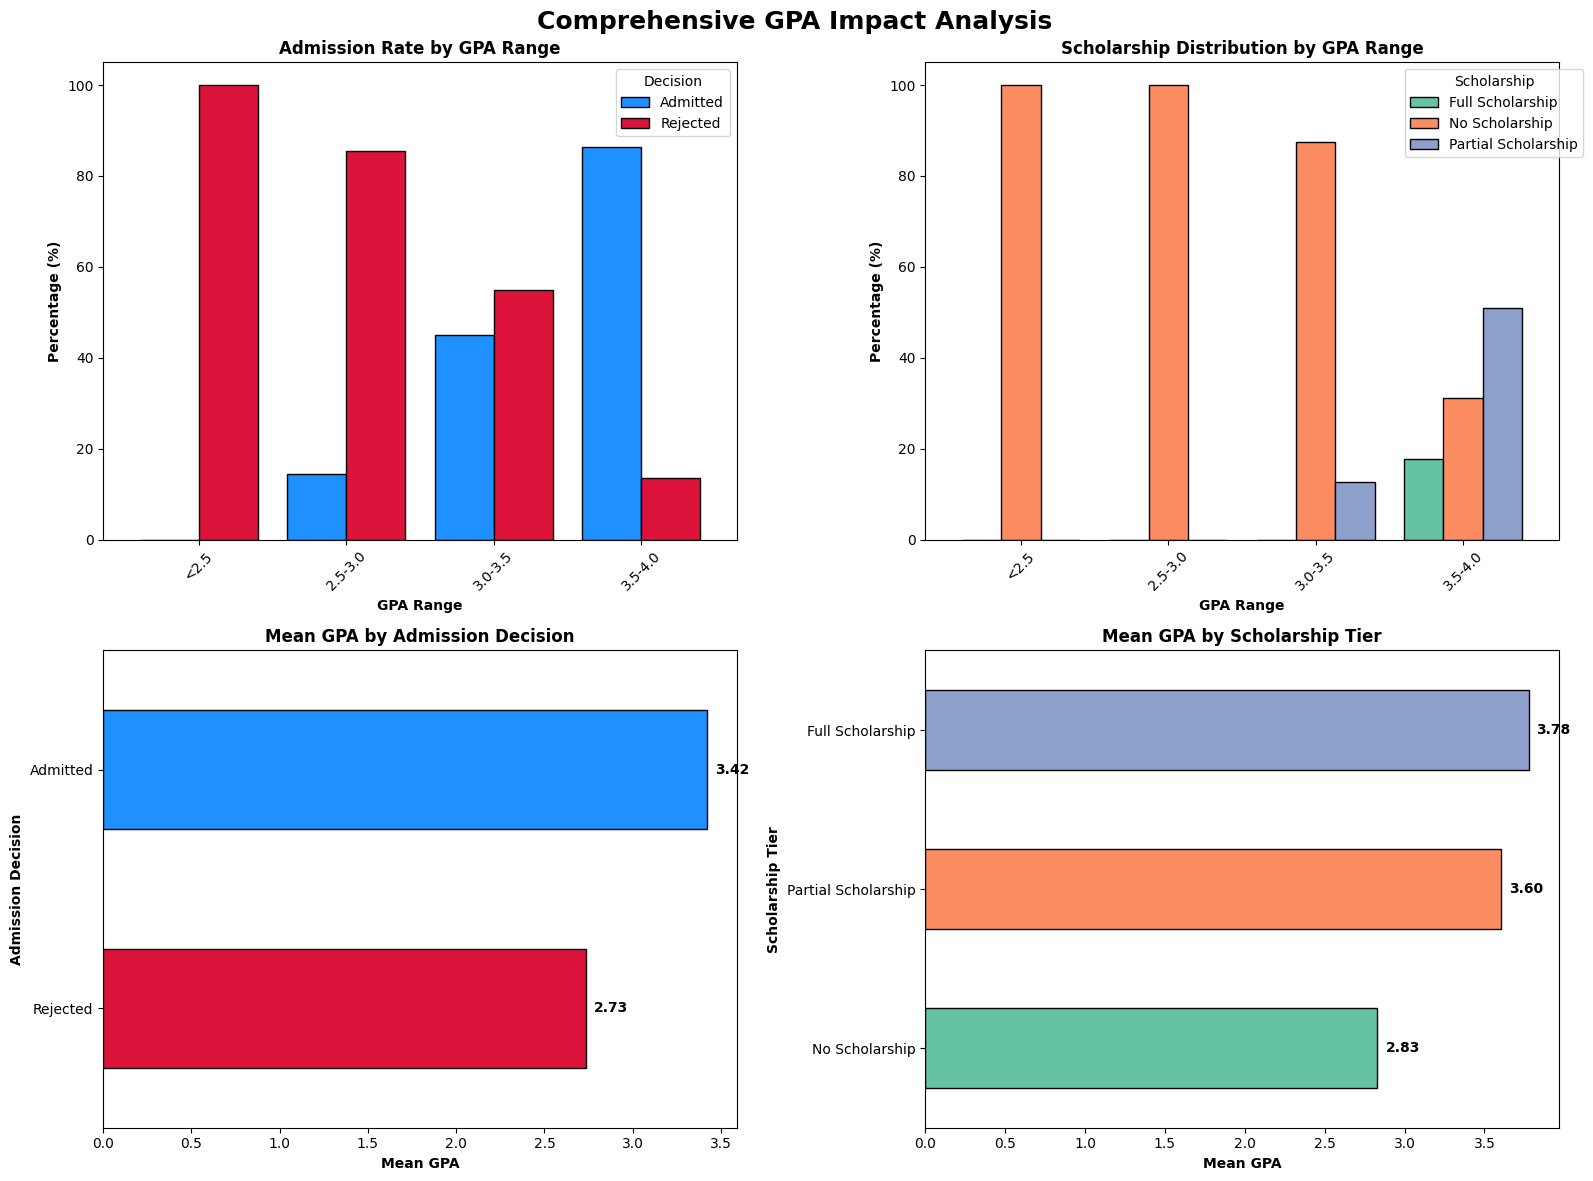

In [26]:
# Combined GPA Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comprehensive GPA Impact Analysis', fontsize=18, fontweight='bold')

# 1. GPA ranges distribution for admission
gpa_bins = [0, 2.5, 3.0, 3.5, 4.0]
gpa_labels = ['<2.5', '2.5-3.0', '3.0-3.5', '3.5-4.0']
df['gpa_range'] = pd.cut(df['previous_gpa'], bins=gpa_bins, labels=gpa_labels)

admission_by_gpa = pd.crosstab(df['gpa_range'], df['admission_decision'], normalize='index') * 100
admission_by_gpa.plot(kind='bar', ax=axes[0, 0], color=['#1E90FF', '#DC143C'], 
                      edgecolor='black', width=0.8)
axes[0, 0].set_title('Admission Rate by GPA Range', fontweight='bold', fontsize=12)
axes[0, 0].set_xlabel('GPA Range', fontweight='bold')
axes[0, 0].set_ylabel('Percentage (%)', fontweight='bold')
axes[0, 0].legend(title='Decision')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. GPA ranges distribution for scholarship
scholarship_by_gpa = pd.crosstab(df['gpa_range'], df['scholarship_tier'], normalize='index') * 100
scholarship_by_gpa.plot(kind='bar', ax=axes[0, 1], color=sns.color_palette('Set2'), 
                        edgecolor='black', width=0.8)
axes[0, 1].set_title('Scholarship Distribution by GPA Range', fontweight='bold', fontsize=12)
axes[0, 1].set_xlabel('GPA Range', fontweight='bold')
axes[0, 1].set_ylabel('Percentage (%)', fontweight='bold')
axes[0, 1].legend(title='Scholarship', bbox_to_anchor=(1.05, 1))
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Mean GPA comparison
mean_gpa_admission = df.groupby('admission_decision')['previous_gpa'].mean().sort_values()
mean_gpa_admission.plot(kind='barh', ax=axes[1, 0], color=['#DC143C', '#1E90FF'], 
                        edgecolor='black')
axes[1, 0].set_title('Mean GPA by Admission Decision', fontweight='bold', fontsize=12)
axes[1, 0].set_xlabel('Mean GPA', fontweight='bold')
axes[1, 0].set_ylabel('Admission Decision', fontweight='bold')
for i, v in enumerate(mean_gpa_admission.values):
    axes[1, 0].text(v + 0.05, i, f'{v:.2f}', va='center', fontweight='bold')

# 4. Mean GPA by scholarship
mean_gpa_scholarship = df.groupby('scholarship_tier')['previous_gpa'].mean().sort_values()
mean_gpa_scholarship.plot(kind='barh', ax=axes[1, 1], color=sns.color_palette('Set2'), 
                          edgecolor='black')
axes[1, 1].set_title('Mean GPA by Scholarship Tier', fontweight='bold', fontsize=12)
axes[1, 1].set_xlabel('Mean GPA', fontweight='bold')
axes[1, 1].set_ylabel('Scholarship Tier', fontweight='bold')
for i, v in enumerate(mean_gpa_scholarship.values):
    axes[1, 1].text(v + 0.05, i, f'{v:.2f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('./images/gpa_comprehensive_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Drop the temporary column
df.drop('gpa_range', axis=1, inplace=True)

In [25]:
# GPA Importance Score
print("\n" + "=" * 80)
print("GPA IMPORTANCE SCORE")
print("=" * 80)

# For Admission
admitted_mean_gpa = df[df['admission_decision'] == 'Admitted']['previous_gpa'].mean()
rejected_mean_gpa = df[df['admission_decision'] == 'Rejected']['previous_gpa'].mean()
admission_difference = abs(admitted_mean_gpa - rejected_mean_gpa)

print("\nAdmission Decision Impact:")
print(f"  • Admitted Mean GPA: {admitted_mean_gpa:.3f}")
print(f"  • Rejected Mean GPA: {rejected_mean_gpa:.3f}")
print(f"  • Difference: {admission_difference:.3f}")
print(f"  • Impact Score: {(admission_difference / rejected_mean_gpa * 100):.2f}%")

# For Scholarship
scholarship_means = df.groupby('scholarship_tier')['previous_gpa'].mean().sort_values()
scholarship_range = scholarship_means.max() - scholarship_means.min()

print("\nScholarship Tier Impact:")
for tier, mean_gpa in scholarship_means.items():
    print(f"  • {tier}: {mean_gpa:.3f}")
print(f"  • Range: {scholarship_range:.3f}")
print(f"  • Impact Score: {(scholarship_range / scholarship_means.min() * 100):.2f}%")


GPA IMPORTANCE SCORE

Admission Decision Impact:
  • Admitted Mean GPA: 3.418
  • Rejected Mean GPA: 2.733
  • Difference: 0.685
  • Impact Score: 25.08%

Scholarship Tier Impact:
  • No Scholarship: 2.830
  • Partial Scholarship: 3.604
  • Full Scholarship: 3.777
  • Range: 0.946
  • Impact Score: 33.43%


## Understanding

From the above analysis we can deduce that previous gpa plays imporant role, in the admission and scholarship, plus passing the language requirement gets more admisison but less affect scholarship. 

We have seen that it has low acceptance rate and even very low scholarship rate, the avg mean of students who go scholarship is above 3.60 even for partial and 3,70 for partial.

Seems like its not that the school has very low acceptance rate, but the students applying have very low grades and getting kicked out by the auto reject may be.

Also we have seen that there is a high demand for the chinise program, from experience have very nice chinise teachers.

Fun fact English score might get you more admitted : To be verified 